# Programaciò paral·lela
## Pràctica 2: Color conversion in CUDA

Following the previous laboratory based on OpenMP, now we are going to work on the same simple algorithm, in CUDA.

The goal of this lab is to learn the basics of CUDA kernels, and CUDA Host code.

This new ipython notebook format, will make things easyer since explanation and code will coexist in the same document, and it will be very clear what you need to do.

Additionally, having the Colab platform available with NVIDIA GPU's makes it simpler than ever. You can learn CUDA from any system, Mac, Windows, Linux, and any hardware, Intel, AMD, NVIDIA, and possibliy even ARM on tablets. You only need a web browser compatible with Colab.

## Structure of the Lab (Pràctica)
You already know the algorithm from the previous lab, but you may not be familiar with this environment.

First we will try to understand a bit this environment, and then we will explain section by section what you have to do. There are 6 sections.

You will have to complete code in the 6 sections, and perform experiments and comment the results in a separated report. Use tables and figures that support both the results you collected and the arguments you make to justify the results.

## The collab environment for CUDA

First of all, you should know that we are executing an iPython notebook in a Google Colab session. The notebook is preconfigured with the type of execution environment we need, a GPU execution environment. But the files we generate, and the pluggins we install or enable, reside on the Google Colab session. All this will be removed when we exit the session either manually or implicitly by closing the broser.

In order to have a GPU available when creating a new notebook, you only have to select the execution environment.
In Spanish, go to "Entorno de ejecución->Cambiar tipo de entorno de ejecución" and then select GPU.

But as we already mentioned, this notebook is already configured, so you don't need to do it again.

Now, the first thing we will see is that we have the nvcc compiler. We can call many bash commands with ! as the first character, in a code block. Next you will find a code block with a call to nvcc (the nvidia CUDA compiler) with a flag that asks for the compiler version.

Click on the block and then a play button will appear on the left. Click on the play button. 


In [0]:
!rm dades.txt # Netejem el fitxer on guardarem les dades
!nvcc --version

rm: cannot remove 'dades.txt': No such file or directory
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


You can also execute it by placing the cursor inside the code block and pressing Shift+Enter

Next you need to install a pluggin, that does not come with the notebook. In the following code block you have the code line to be executed. You will have to execute this code every time you open the notebook.

In [0]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-pvks5bjf
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-pvks5bjf
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4307 sha256=87d4ade2297439d0006c9972cbc47dbf7abf293cd3e3be1514ff41001233502e
  Stored in directory: /tmp/pip-ephem-wheel-cache-cbvw0nr9/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


Now, you can compile and execute CUDA code, just by puting the same code you would put ina .cu file, just by adding %%cu as the first line.

Next, you have a code example. Try it! Read the comments to help you understand it. It will be very useful for the tasks you have to do.

In [0]:
%%cu
#include <stdio.h>
#include <stdlib.h>

// Function to print the cuda errors
void cuCheck(cudaError_t err) {
    if(err!=cudaSuccess) {
          printf("CUDA error copying to Host: %s\n", cudaGetErrorString(err));
    }
}

// This macros help with capturing the possible cuda errors and printing
// the error name to help the developer.
// Kernels are always asynchronous with respect to the Host, so they don't return
// any value. Then to see if any error happened, you should call cudaGetLastError
// and pass the result to cuCheck()
// Use the macros instead, to make it simpler.
#define CU_CHECK(a) cuCheck(a)
#define CU_CHECK_LAST_ERROR cuCheck(cudaGetLastError())

// Device code or Kernel
__global__ void add(int a, int b, int* __restrict d_c) {
    *d_c = a * b;
}

// Host code
int main() {
    
    // Host variables a & b
    int a = 3, b = 5, h_c = 0;

    // Host variable that will store a Device pointer wich we can later on 
    // download to the Host.
    // As this variable will contain pointers that are only valid in
    // the Device (the GPU) it will be invalid to access them from
    // Host code. We only can use them in the right cuda API calls
    // or inside a cuda Kernel.
    // So in this part of the code you won't be able to do d_c[0], for instance
    int *d_c;

    // Size of the data contained in variables a, b and c.
    int dataSize = sizeof(int);

    // Reserve Device memory using the cuda API
    // cudaMalloc will place a Device pointer inside d_c.
    CU_CHECK(
        cudaMalloc((void **)&d_c, dataSize)
    );

    // Launch add() kernel on GPU
    // Notice that a and b are not pointers. Therefore the kernel call will
    // copy their values but the variables inside the kernel will not be the same.
    // If we modify a and b inside the kernel, it will not change a and b in this
    // Host code. This, indeed is the same behavior as any C/C++ function call.
    // In the case of d_c, it will copy the pointer contained in d_c, 
    // so we will be able to modify the contents of d_c from the kernel. But to read 
    // them from this Host code, we will have to do something else.
    add<<<1,1>>>(a, b, d_c);
    CU_CHECK_LAST_ERROR;

    CU_CHECK(
        // Copy result back to host
        cudaMemcpy(&h_c, d_c, dataSize, cudaMemcpyDeviceToHost)
    );

    int numDevs=0;
    CU_CHECK(
        cudaGetDeviceCount(&numDevs)
    );

    cudaDeviceProp prop;
    CU_CHECK(
        cudaGetDeviceProperties(&prop, 0)
    );
    printf("Device Number: %d\n", 0);
    printf("  Device name: %s\n", prop.name);
    printf("  Memory Clock Rate (KHz): %d\n",
          prop.memoryClockRate);
    printf("  Memory Bus Width (bits): %d\n",
          prop.memoryBusWidth);
    printf("  Peak Memory Bandwidth (GB/s): %f\n\n",
          2.0*prop.memoryClockRate*(prop.memoryBusWidth/8)/1.0e6);
    printf("Num devices %d\n", numDevs);

    printf("Result of multiplying %d * %d is %d\n",a,b,h_c);
    // Cleanup
    CU_CHECK(
      cudaFree(d_c)
    );
    return 0;
}

Device Number: 0
  Device name: Tesla P4
  Memory Clock Rate (KHz): 3003000
  Memory Bus Width (bits): 256
  Peak Memory Bandwidth (GB/s): 192.192000

Num devices 1
Result of multiplying 3 * 5 is 15



Ok, cool! But what if I want to have some code in a .h file, the cuda kernels in an other .h file, and include both so that I can reuse code?

Ok, let's try to put the macros and cuCheck function in a .h file, the kernel in an other .h file and the rest in a .cu file, and compile and execute everything. 

In [0]:
%%cuda --name utils.h
#include <iostream>

void cuCheck(cudaError_t err, const std::string message = "CUDA error:") {
  if(err!=cudaSuccess) {
    std::cout << message << " ERROR " << cudaGetErrorString(err) << std::endl;
  }
}
#define CU_CHECK(a) cuCheck(a)
#define CU_CHECK2(a, b) cuCheck(a, b)
#define CU_CHECK_LAST_ERROR cuCheck(cudaGetLastError())

'File written in /content/src/utils.h'

In [0]:
%%cuda --name kernels.h
__global__ void add(int a, int b, int* __restrict d_c) {
    *d_c = a * b;
}

'File written in /content/src/kernels.h'

In [0]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include "/content/src/utils.h"
#include "/content/src/kernels.h"

// Host code
int main() {
    int a = 3, b = 5, h_c = 0;
    int *d_c;
    int dataSize = sizeof(int);
    CU_CHECK(cudaMalloc((void **)&d_c, dataSize));
    add<<<1,1>>>(a, b, d_c);
    CU_CHECK_LAST_ERROR;
    CU_CHECK(cudaMemcpy(&h_c, d_c, dataSize, cudaMemcpyDeviceToHost));
    int numDevs=0;
    CU_CHECK(cudaGetDeviceCount(&numDevs));
    cudaDeviceProp prop;
    CU_CHECK(cudaGetDeviceProperties(&prop, 0));
    printf("Device Number: %d\n", 0);
    printf("  Device name: %s\n", prop.name);
    printf("  Memory Clock Rate (KHz): %d\n",
          prop.memoryClockRate);
    printf("  Memory Bus Width (bits): %d\n",
          prop.memoryBusWidth);
    printf("  Peak Memory Bandwidth (GB/s): %f\n\n",
          2.0*prop.memoryClockRate*(prop.memoryBusWidth/8)/1.0e6);
    printf("Num devices %d\n", numDevs);
    printf("Result of multiplying %d * %d is %d\n",a,b,h_c);
    CU_CHECK(cudaFree(d_c));
    return 0;
}

Device Number: 0
  Device name: Tesla P4
  Memory Clock Rate (KHz): 3003000
  Memory Bus Width (bits): 256
  Peak Memory Bandwidth (GB/s): 192.192000

Num devices 1
Result of multiplying 3 * 5 is 15



VERY IMPORTANT!!! On each Colab session, the GPU that Google Colab provides can be different. Take it into account when you perform experiments, so that you compare results for the same GPU.

If you have to repeat all the experiments, well, it's not that hard, just click play in all the code blocks one by one.

Great!! Now we can start the lab :-D

##Section 1:

Try to complete the following code, and make it compile. Remember that you have some slides and documents, and the CUDA API specification in the following link: https://docs.nvidia.com/cuda/cuda-runtime-api/index.html

Also, you can search in Google, things like "How to allocate CUDA memory". And so on. Be brave! Is not so difficult.

### First, complete the allocation functions.

In [0]:
%%cuda --name memory_functions.h
void allocGPUData(int width, int height, uchar3** d_brg, uchar4** d_rgba){
  // Alloc gpu pointers
  CU_CHECK2(cudaMalloc(d_brg, sizeof(uchar3)*width*height), "Alloc d_brg:");
  // Can you finish this one? Replace cudaSucces with the proper cuda API call
  CU_CHECK2(cudaMalloc(d_rgba, sizeof(uchar4)*width*height), "Alloc d_rgba:");
}
void copyAndInitializeGPUData(int width, int height, uchar3* h_brg, uchar3* d_brg, uchar4* d_rgba, cudaStream_t stream=0) {
  // Copy data to GPU
  CU_CHECK2(cudaMemcpy(d_brg, h_brg, width*height*sizeof(uchar3), cudaMemcpyHostToDevice), "Copy h_brg to d_brg:");
  // Init output buffer to 0
  CU_CHECK2(cudaMemset(d_rgba, 0, width*height*sizeof(uchar4)), "Memset d_rgba:");
}
void freeCUDAPointers(uchar3* d_brg, uchar4* d_rgba) {
  // Free cuda pointers. Replace the cudaErrorInvalidValue flag
  // with the proper cuda API call, to free the GPU pointers
  CU_CHECK2(cudaFree(d_brg), "Cuda free d_bgr:");
  CU_CHECK2(cudaFree(d_rgba), "Cuda free d_rgba:");
  // Clean GPU device
  CU_CHECK2(cudaDeviceReset(), "Cuda device reset:");
}

'File written in /content/src/memory_functions.h'

### When completed, test that they work with this small main function. If you execute it without completing the previous code, it will show some errors.

In [0]:
%%cu
#include <cuda.h>
#include "/content/src/utils.h"
#include "/content/src/memory_functions.h"

#define WIDTH 10
#define HEIGHT 10

int main() {

  uchar3 *h_brg, *d_brg;
  uchar4 *h_rgba, *d_rgba;

  h_brg = (uchar3*)malloc(sizeof(uchar3)*WIDTH*HEIGHT);
  h_rgba = (uchar4*)malloc(sizeof(uchar4)*WIDTH*HEIGHT);

  allocGPUData(WIDTH, HEIGHT, &d_brg, &d_rgba);
  copyAndInitializeGPUData(WIDTH, HEIGHT, h_brg, d_brg, d_rgba);
  freeCUDAPointers(d_brg, d_rgba);

  return 0;
}

### Ok, now that we have the allocation, copy and free functions implemented, let's continue with the CPU function that will check the results. This one it's already implemented, you only need to click play to have it available.

In [0]:
%%cuda --name check_results.h
bool checkResults(uchar4* rgba, uchar3* brg, int size) {
  bool correct = true;
  for (int i=0; i < size; ++i) {
    // In case you want to see actual values
    if (i==0 || i==1 || i==(size-1) ) {
      unsigned char x, y, z, w;
      x = rgba[i].x;
      y = rgba[i].y;
      z = rgba[i].z;
      w = rgba[i].w;
      std::cout << "First position x=" << (unsigned int)x << " y=" << (unsigned int)y << " z=" << (unsigned int)z << " w=" << (unsigned int)w << std::endl;
    }
    correct &= rgba[i].x == brg[i].y;
    correct &= rgba[i].y == brg[i].z;
    correct &= rgba[i].z == brg[i].x;
    correct &= rgba[i].w == 255;
    /*if(!correct)
    {
        std::cout << "First position x=" << (unsigned int)rgba[i].x << " y=" << (unsigned int)rgba[i].y << " z=" << (unsigned int)rgba[i].z << " w=" << (unsigned int)rgba[i].w << std::endl;
        correct = true;
    }*/
  }
  return correct;
}

'File written in /content/src/check_results.h'

### Now the interesting part, the kernel and the code to configure and launch it. The kernel it's almost exactly the same code as the OpenMP lab, only we replaced the forloops with something that you need to implement.

Remember, that we have threads with indexes. This indexes are used to tell each CUDA thread, which data do they have to read or write.

The structs that contain those indexes are in the documentation you have available in campusvirtual. Please check the docs.

In [0]:
%%cuda --name cuda_launcher.h
#include <stdio.h>


// BIDIMENSIONAL KERNEL
__global__ void convertBRG2RGBA(uchar3 *brg, uchar4* rgba, int width, int height) {
  int x = threadIdx.x + (blockIdx.x * blockDim.x); //Use the thread id and block id's to compute x 
  int y = threadIdx.y + (blockIdx.y * blockDim.y); //Use the thread id and block id's to compute y

	// Protection to avoid segmentation fault
	if (x < width && y < height) {	
	    rgba[width * y + x].x = brg[width * y + x].y;
	    rgba[width * y + x].y = brg[width * y + x].z;
	    rgba[width * y + x].z = brg[width * y + x].x;
	    rgba[width * y + x].w = 255;
	}
}

void executeKernelconvertBRG2RGBA(int width, int height, uchar3* d_brg, uchar4* d_rgba, int numIters, cudaStream_t stream=0) {
  // Execute the GPU kernel
  dim3 block(256, 4, 1);
  dim3 grid(ceil(width/(float)block.x),ceil(height/(float)block.y) , 1);

  auto t1 = std::chrono::high_resolution_clock::now();
  for (int i=0; i<numIters; ++i) {
    convertBRG2RGBA<<<grid, block, 0, stream>>>(d_brg, d_rgba, width, height);
  }
  CU_CHECK2(cudaDeviceSynchronize(), "cudaDeviceSynchronize:");
  auto t2 = std::chrono::high_resolution_clock::now();
  auto duration = std::chrono::duration_cast<std::chrono::microseconds>( t2 - t1 ).count();
  FILE* fp = fopen("dades.txt", "a");
  fprintf(fp, "%lf\n", (double) duration);
  fclose(fp);
  std::cout << "convertBRG2RGBA time for " << numIters << " iterations = "<< duration << "us" << std::endl;
}

'File written in /content/src/cuda_launcher.h'

### MAIN EXPERIMENT 
Try all the previous code, with the following main. If you did not finish all the previous code, this file will show some execution errors.

The code is divided in two parts, one to define the parameters of the experiment and the other one is the main function with the experiment it self.

The experiment is the code that creates a BRG image in CPU, allocates GPU memory, copies the BRG image to GPU memory, and executes a GPU kernel to convert the BRG image into a RGBA image. The output of the kernel is another GPU pointer, so after the kernel execution, we have to copy back the results.

In [0]:
%%cuda --name experiment_settings.h
#pragma once
#define WIDTH 3840
#define HEIGHT 2160
#define EXPERIMENT_ITERATIONS 100

'File written in /content/src/experiment_settings.h'

In [0]:
%%cuda --name experiment.h
#include <cuda.h>
#include <chrono>
#include "/content/src/utils.h"
#include "/content/src/memory_functions.h"
#include "/content/src/check_results.h"
#include "/content/src/cuda_launcher.h"
#include "/content/src/experiment_settings.h"

void executeExperiment() {
  uchar3 *h_brg, *d_brg;
  uchar4 *h_rgba, *d_rgba;

  int bar_widht = HEIGHT/3;

  // Alloc and generate BRG bars.
  h_brg = (uchar3*)malloc(sizeof(uchar3)*WIDTH*HEIGHT);
  for (int i=0; i < WIDTH * HEIGHT; ++i) {
    if (i < bar_widht) {
      uchar3 temp = {255, 0, 0};
      h_brg[i] = temp; 
    } else if (i < bar_widht*2) {
      uchar3 temp = {0, 255, 0};
      h_brg[i] = temp;
    } else { 
      uchar3 temp = {0, 0, 255};
      h_brg[i] = temp;
    }
  }

  // Alloc RGBA pointers
  h_rgba = (uchar4*)malloc(sizeof(uchar4)*WIDTH*HEIGHT);

  // Alloc gpu pointers
  allocGPUData(WIDTH, HEIGHT, &d_brg, &d_rgba);
  
  // Prepare and copy data to GPU
  copyAndInitializeGPUData(WIDTH, HEIGHT, h_brg, d_brg, d_rgba);

  // Execute the GPU kernel
  executeKernelconvertBRG2RGBA(WIDTH, HEIGHT, d_brg, d_rgba, EXPERIMENT_ITERATIONS);

  // Copy data back from GPU to CPU, without streams
  CU_CHECK2(cudaMemcpy(h_rgba, d_rgba, sizeof(uchar4)*WIDTH*HEIGHT, cudaMemcpyDeviceToHost), "Cuda memcpy Device to Host: ");
    
  // Check results
  bool ok = checkResults(h_rgba, h_brg, WIDTH*HEIGHT);
  if (ok) {
      std::cout << "Executed!! Results OK." << std::endl;
  } else {
      std::cout << "Executed!! Results NOT OK." << std::endl;
  }

  // Free CPU pointers
  free(h_rgba);
  free(h_brg);

  // Free cuda pointers
  freeCUDAPointers(d_brg, d_rgba);
}

'File written in /content/src/experiment.h'

In [0]:
%%cu
#include "/content/src/experiment.h"
int main() {

  executeExperiment();

  return 0;
}

convertBRG2RGBA time for 100 iterations = 52725us
First position x=0 y=0 z=255 w=255
First position x=0 y=0 z=255 w=255
First position x=0 y=255 z=0 w=255
Executed!! Results OK.



##Section 2:
Implement a version of the kernel and launcher that uses a one dimensional cuda GRID. That is, there is no more x and y, only x.

Modify the code below, click play, and then click play in the Main Experiment block, in Section 1.

Try different values of BLOCK_SIZE.

Check if there is any execution time improvement, compared to Section 1.


In [0]:
%%cuda --name cuda_launcher.h

#define BLOCK_SIZE 256

// UNIDIMENSIONAL KERNEL
__global__ void convertBRG2RGBA(uchar3 *brg, uchar4* rgba, int width, int height) {
  int x = threadIdx.x + (blockIdx.x * blockDim.x); //Use the thread id and block id's to compute x 
  
	// Protection to avoid segmentation fault
	if (x < width * height) {	
	    rgba[x].x = brg[x].y;
	    rgba[x].y = brg[x].z;
	    rgba[x].z = brg[x].x;
	    rgba[x].w = 255;
	}
}

void executeKernelconvertBRG2RGBA(int width, int height, uchar3* d_brg, uchar4* d_rgba, int numIters, cudaStream_t stream=0) {
  // Execute the GPU kernel
  dim3 block(BLOCK_SIZE, 1, 1);
  dim3 grid(ceil(width*height/(float)block.x), 1, 1);

  auto t1 = std::chrono::high_resolution_clock::now();
  for (int i=0; i<numIters; ++i) {
    convertBRG2RGBA<<<grid, block, 0, stream>>>(d_brg, d_rgba, width, height);
  }
  CU_CHECK2(cudaDeviceSynchronize(), "cudaDeviceSynchronize:");
  auto t2 = std::chrono::high_resolution_clock::now();
  auto duration = std::chrono::duration_cast<std::chrono::microseconds>( t2 - t1 ).count();
  FILE* fp = fopen("dades.txt", "a");
  fprintf(fp, "%lf\n", (double) duration);
  fclose(fp);
  std::cout << "convertBRG2RGBA time for " << numIters << " iterations = "<< duration << "us" << std::endl;
}

'File written in /content/src/cuda_launcher.h'

In [0]:
%%cu
#include "/content/src/experiment.h"
int main() {

  executeExperiment();

  return 0;
}

convertBRG2RGBA time for 100 iterations = 47168us
First position x=0 y=0 z=255 w=255
First position x=0 y=0 z=255 w=255
First position x=0 y=255 z=0 w=255
Executed!! Results OK.



Change the experiment settings, by executing more iterations and compare the unidimensional kernel with the bidimensional kernel.

Comment the results in the report.

In [0]:
%%cuda --name experiment_settings.h
#pragma once
#define WIDTH 3840
#define HEIGHT 2160
#define EXPERIMENT_ITERATIONS 100 //try different values

'File written in /content/src/experiment_settings.h'

## Section 3:

Starting from Section 2, (use the best BLOCK_SIZE you found) try to optimize the memory accesses in some way, without using shared memory.

Comment in the report which memory access problems you observe. Are the memory accesses aligned, and therfore coalesced?

Remember that opposite to what the CPU compilers do, the nvcc compiler does not optimize the memory accesses in structs

Remember also that GPU memory is organized in blocks of 4 bytes, and any array based on data elements that are not multiple of 2, will not be alligned. To be coalesced (specially in old architectures), it also has to be multiple of 4.

In [0]:
%%cuda --name cuda_launcher.h

#define BLOCK_SIZE 256

// UNIDIMENSIONAL KERNEL BETTER MEMORY ACCESS
__global__ void convertBRG2RGBA(uchar3 *brg, uchar4* rgba, int width, int height) {
  int x = threadIdx.x + (blockIdx.x * blockDim.x); //Use the same code as in section 2 in this line
  
	// Protection to avoid segmentation fault
	if (x < width * height) {	
	    uchar3 tmp_3 = brg[x];
      /*uint3 tmp_3 = ((uint3*)brg)[x];

      uchar4* tmp1 = (uchar4*)(&tmp_3.x);
      uchar4* tmp2 = (uchar4*)(&tmp_3.y);
      uchar4* tmp3 = (uchar4*)(&tmp_3.z);

      
      uchar4 pix1 = make_uchar4(tmp1->y, tmp1->z, tmp1->x, 255);
      uchar4 pix2 = make_uchar4(tmp2->x, tmp2->y, tmp1->w, 255);
      uchar4 pix3 = make_uchar4(tmp2->w, tmp3->x, tmp2->z, 255);
      uchar4 pix4 = make_uchar4(tmp3->z, tmp3->w, tmp3->y, 255);
      ((uint4*)rgba)[x] = make_uint4(*(uint*)(&pix1), *(uint*)(&pix2), *(uint*)(&pix3), *(uint*)(&pix4));*/

      uchar4 tmp_4;
      
      tmp_4.x = tmp_3.y;
      tmp_4.y = tmp_3.z;
      tmp_4.z = tmp_3.x;
      tmp_4.w = 255;
      
      rgba[x] = tmp_4;
	}
}

void executeKernelconvertBRG2RGBA(int width, int height, uchar3* d_brg, uchar4* d_rgba, int numIters, cudaStream_t stream=0) {
  // Execute the GPU kernel
  dim3 block(BLOCK_SIZE, 1, 1);
  dim3 grid(ceil(width*height/(float)block.x), 1, 1);
  //dim3 grid(ceil(((width*height)/4)/(float)block.x), 1, 1);

  auto t1 = std::chrono::high_resolution_clock::now();
  for (int i=0; i<numIters; ++i) {
    convertBRG2RGBA<<<grid, block, 0, stream>>>(d_brg, d_rgba, width, height);
  }
  CU_CHECK2(cudaDeviceSynchronize(), "cudaDeviceSynchronize:");
  auto t2 = std::chrono::high_resolution_clock::now();
  auto duration = std::chrono::duration_cast<std::chrono::microseconds>( t2 - t1 ).count();
  FILE* fp = fopen("dades.txt", "a");
  fprintf(fp, "%lf\n", (double) duration);
  fclose(fp);
  std::cout << "convertBRG2RGBA time for " << numIters << " iterations = "<< duration << "us" << std::endl;
}

'File written in /content/src/cuda_launcher.h'

In [0]:
%%cuda --name test3.cu
#include "/content/src/experiment.h"
int main() {

  executeExperiment();

  return 0;
}

'File written in /content/src/test3.cu'

In [0]:
!nvcc src/test3.cu -o test3

In [0]:
!nvprof ./test3

==420== NVPROF is profiling process 420, command: ./test3
convertBRG2RGBA time for 100 iterations = 38819us
First position x=0 y=0 z=255 w=255
First position x=0 y=0 z=255 w=255
First position x=0 y=255 z=0 w=255
Executed!! Results OK.
==420== Profiling application: ./test3
==420== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   58.61%  38.465ms       100  384.65us  384.13us  385.76us  convertBRG2RGBA(uchar3*, uchar4*, int, int)
                   33.04%  21.681ms         1  21.681ms  21.681ms  21.681ms  [CUDA memcpy DtoH]
                    8.35%  5.4820ms         1  5.4820ms  5.4820ms  5.4820ms  [CUDA memcpy HtoD]
                    0.00%  1.7600us         1  1.7600us  1.7600us  1.7600us  [CUDA memset]
      API calls:   62.25%  208.70ms         2  104.35ms  253.04us  208.44ms  cudaMalloc
                   17.09%  57.301ms         1  57.301ms  57.301ms  57.301ms  cudaDeviceReset
                   11.37%  38.13

##Section 4:
Now optimize the GPU memory accesses so that each thread always reads at least one element of 4 bytes. Use shared memory to that end.

Look at the PDF Lab2CUDA in the campus, an read the last two pages. There you have a graphical explanation of the kernel issues. For this section you only need to understand the first figure.

About shared memory: we will refresh some concepts.

Shared memory, is a kind of memory that is visible only by the cuda threads of a thread block. Cuda threads from different thread blocks can not see the shared memory of other threadblocks.

Shared memory is a limited resource. Depending on the GPU model, you may have from 32KB to 64KB of shared memory. Additionally, this memory is not used only by one threadblock. It is partitioned in as many independent blocks as thread blocks can execute in a single Streaming Multiprocessor (check the documentation if you don't know what a SM is). 

So when you are defining the amount of shared memory you want, you are defining the amount of memory, every thread block will have available.

If you reserve 64KB of shared memory, in a GPU that has this capacity, only one thread block will execute on each SM, which is super slow. Each SM can concurrently execute from 8 to 32 thread blocks. For the best performance, you usually want the greatest amount of thread blocks active on each SM.

Therefore, you what to use the least shared memory possible, and only use it when it has clear benefits.


In [0]:
%%cuda --name cuda_launcher.h
#include "/content/src/experiment_settings.h"

// Try different vaues of BLOCK_SIZE
#define BLOCK_SIZE 256

// Number of 4 byte elements that we can make out of BLOCK_SIZE elements of 3 bytes
#define N_ELEMS_3_4_TBLOCK (BLOCK_SIZE * 3)/4
#define N_ELEMS_3_4_IMAGE (WIDTH*HEIGHT * 3)/4

// UNIDIMENSIONAL KERNEL SHARED MEMORY
__global__ void convertBRG2RGBA(uchar3 *brg, uchar4* rgba, int width, int height) {
  int position = threadIdx.x + (blockIdx.x * N_ELEMS_3_4_TBLOCK);// use N_ELEMS_3_4_TBLOCK to compute the position of each thread when we read brg as if it had elements of 4 bytes
  __shared__ uchar4 bgrShared[N_ELEMS_3_4_TBLOCK];
  
  if(threadIdx.x < N_ELEMS_3_4_TBLOCK && position < N_ELEMS_3_4_IMAGE) {
      bgrShared[threadIdx.x] = reinterpret_cast<uchar4*>(brg)[position];
  }

  __syncthreads();
  
  position = threadIdx.x + (blockIdx.x * blockDim.x); // recompute position without N_ELEMS_3_4_TBLOCK to write the results
	// Protection to avoid segmentation fault
	if (position < width*height) {	
        uchar3 local = reinterpret_cast<uchar3*>(bgrShared)[threadIdx.x];
        rgba[position] = make_uchar4(local.y,local.z,local.x,255);
	}
}

void executeKernelconvertBRG2RGBA(int width, int height, uchar3* d_brg, uchar4* d_rgba, int numIters, cudaStream_t stream=0) {
  // Execute the GPU kernel
  dim3 block(BLOCK_SIZE, 1, 1);
  dim3 grid(ceil(width*height/(float)block.x), 1, 1);

  auto t1 = std::chrono::high_resolution_clock::now();
  for (int i=0; i<numIters; ++i) {
    convertBRG2RGBA<<<grid, block, 0, stream>>>(d_brg, d_rgba, width, height);
  }
  CU_CHECK2(cudaDeviceSynchronize(), "cudaDeviceSynchronize:");
  auto t2 = std::chrono::high_resolution_clock::now();
  auto duration = std::chrono::duration_cast<std::chrono::microseconds>( t2 - t1 ).count();
  FILE* fp = fopen("dades.txt", "a");
  fprintf(fp, "%lf\n", (double) duration);
  fclose(fp);
  std::cout << "convertBRG2RGBA time for " << numIters << " iterations = "<< duration << "us" << std::endl;
}

'File written in /content/src/cuda_launcher.h'

In [0]:
%%cuda --name section_4.cu
#include "/content/src/experiment.h"
int main() {

  executeExperiment();

  return 0;
}

'File written in /content/src/section_4.cu'

In [0]:
!nvcc src/section_4.cu -o section_4

In [0]:
!nvprof ./section_4 2> a.txt

convertBRG2RGBA time for 100 iterations = 39266us
First position x=0 y=0 z=255 w=255
First position x=0 y=0 z=255 w=255
First position x=0 y=255 z=0 w=255
Executed!! Results OK.


In [0]:
!cat a.txt
!cat dades.txt

==469== NVPROF is profiling process 469, command: ./section_4
==469== Profiling application: ./section_4
==469== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   59.32%  38.935ms       100  389.35us  388.09us  390.87us  convertBRG2RGBA(uchar3*, uchar4*, int, int)
                   31.80%  20.872ms         1  20.872ms  20.872ms  20.872ms  [CUDA memcpy DtoH]
                    8.87%  5.8240ms         1  5.8240ms  5.8240ms  5.8240ms  [CUDA memcpy HtoD]
                    0.00%  1.0240us         1  1.0240us  1.0240us  1.0240us  [CUDA memset]
      API calls:   66.37%  242.99ms         2  121.49ms  290.32us  242.70ms  cudaMalloc
                   14.71%  53.843ms         1  53.843ms  53.843ms  53.843ms  cudaDeviceReset
                   10.53%  38.546ms         1  38.546ms  38.546ms  38.546ms  cudaDeviceSynchronize
                    7.66%  28.054ms         2  14.027ms  6.0417ms  22.013ms  cudaMemcpy
               

##Section 5:

Now, following the explanation in the Lab2CUDA, try to implement the described algorithm. Take into account that the piece of code that reads from temp variables and writes in pix_write, requires some changes.

In [0]:
%%cuda --name cuda_launcher.h
#include "/content/src/experiment_settings.h"

// Try different vaues of BLOCK_SIZE
#define BLOCK_SIZE 256

// Number of 4 byte elements that we can make out of BLOCK_SIZE elements of 3 bytes
#define N_ELEMS_3_4_TBLOCK (BLOCK_SIZE * 3)/4
#define N_ELEMS_3_4_IMAGE (WIDTH*HEIGHT * 3)/4
#define N_ELEMS_3_4_TBLOCK_3 N_ELEMS_3_4_TBLOCK/3

// UNIDIMENSIONAL KERNEL SHARED MEMORY
__global__ void convertBRG2RGBA(uchar3 *brg, uchar4* rgba, int width, int height) {
  int position = threadIdx.x + (blockIdx.x * N_ELEMS_3_4_TBLOCK);// use N_ELEMS_3_4_TBLOCK to compute the position of each thread when we read brg as if it had elements of 4 bytes
  __shared__ uchar4 bgrShared[N_ELEMS_3_4_TBLOCK];
  
  if(threadIdx.x < N_ELEMS_3_4_TBLOCK && position < N_ELEMS_3_4_IMAGE) {
      bgrShared[threadIdx.x] = reinterpret_cast<uchar4*>(brg)[position];
  }

  __syncthreads();

  /* pix_write -> La memoria para acceso  */
  __shared__ uchar4 pix_write[1024];

  /* Cada 3 threads escribimos los bytes a memoria compartida */
  if(threadIdx.x < N_ELEMS_3_4_TBLOCK_3)
  {
      /* Calculem els temp */
      uchar4 temp1, temp2, temp3;
      temp1 = bgrShared[3 * threadIdx.x];
      temp2 = bgrShared[3 * threadIdx.x + 1];
      temp3 = bgrShared[3 * threadIdx.x + 2];

      int position2 = threadIdx.x + (blockIdx.x * N_ELEMS_3_4_TBLOCK_3);

      /* Asignamos la memoria */
      pix_write[threadIdx.x * 4]     = make_uchar4(temp1.y, temp1.z, temp1.x, 255);
      pix_write[threadIdx.x * 4 + 1] = make_uchar4(temp2.x, temp2.y, temp1.w, 255);
      pix_write[threadIdx.x * 4 + 2] = make_uchar4(temp2.w, temp3.x, temp2.z, 255);
      pix_write[threadIdx.x * 4 + 3] = make_uchar4(temp3.z, temp3.w, temp3.y, 255);
   
      ((uint4*)rgba)[position2] = ((uint4*)pix_write)[threadIdx.x];
  }
}

void executeKernelconvertBRG2RGBA(int width, int height, uchar3* d_brg, uchar4* d_rgba, int numIters, cudaStream_t stream=0) {
  // Execute the GPU kernel
  dim3 block(BLOCK_SIZE, 1, 1);
  dim3 grid(ceil(width*height/(float)block.x), 1, 1);

  auto t1 = std::chrono::high_resolution_clock::now();
  for (int i=0; i<numIters; ++i) {
    convertBRG2RGBA<<<grid, block, 0, stream>>>(d_brg, d_rgba, width, height);
  }
  CU_CHECK2(cudaDeviceSynchronize(), "cudaDeviceSynchronize:");
  auto t2 = std::chrono::high_resolution_clock::now();
  auto duration = std::chrono::duration_cast<std::chrono::microseconds>( t2 - t1 ).count();
  FILE* fp = fopen("dades.txt", "a");
  fprintf(fp, "%lf\n", (double) duration);
  fclose(fp);
  std::cout << "convertBRG2RGBA time for " << numIters << " iterations = "<< duration << "us" << std::endl;
}

'File written in /content/src/cuda_launcher.h'

In [0]:
%%cuda --name section_5.cu
#include "/content/src/experiment.h"
int main() {

  executeExperiment();

  return 0;
}

'File written in /content/src/section_5.cu'

In [0]:
!nvcc src/section_5.cu -o section_5

In [0]:
!nvprof ./section_5

==522== NVPROF is profiling process 522, command: ./section_5
convertBRG2RGBA time for 100 iterations = 40322us
First position x=0 y=0 z=255 w=255
First position x=0 y=0 z=255 w=255
First position x=0 y=255 z=0 w=255
Executed!! Results OK.
==522== Profiling application: ./section_5
==522== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   60.39%  39.987ms       100  399.87us  397.46us  401.81us  convertBRG2RGBA(uchar3*, uchar4*, int, int)
                   31.29%  20.720ms         1  20.720ms  20.720ms  20.720ms  [CUDA memcpy DtoH]
                    8.32%  5.5075ms         1  5.5075ms  5.5075ms  5.5075ms  [CUDA memcpy HtoD]
                    0.00%  1.0240us         1  1.0240us  1.0240us  1.0240us  [CUDA memset]
      API calls:   62.46%  206.99ms         2  103.49ms  257.22us  206.73ms  cudaMalloc
                   16.46%  54.564ms         1  54.564ms  54.564ms  54.564ms  cudaDeviceReset
                   11.98

##Section 6:

Change all the host code necessary, to use cuda streams. Here you have an example.

In [0]:
%%cu
#include <iostream>

__global__ void square(int* d_input, int* d_output) {
    int x = threadIdx.x + blockIdx.x * blockDim.x;

    int val = d_input[x];
    // We exploit the temporal locality of the value stored in d_output[x]
    d_output[x] = val*val;
}

static const size_t dataSize = sizeof(int)*1024;

int main() {
    
    int *h_input, *h_output;
    h_input = (int*)malloc(dataSize);
    h_output = (int*)malloc(dataSize);

    for (int i=0; i<1024; ++i) h_input[i]=i;

    int *d_input, *d_output;
    cudaMalloc(&d_input, dataSize);
    cudaMalloc(&d_output, dataSize);

    cudaStream_t stream;
    cudaStreamCreate(&stream);

    dim3 block(512);
    dim3 grid(2);

    // The CPU thread does not wait that any of the following actions finish
    // It only asks the GPU to do the copies and the kernel and continues
    cudaMemcpyAsync(d_input, h_input, dataSize, cudaMemcpyHostToDevice, stream);
    square<<<grid, block, 0, stream>>>(d_input, d_output);
    cudaMemcpyAsync(h_output, d_output, dataSize, cudaMemcpyDeviceToHost, stream);

    // Here, we wait for all the orders enqueued in stream, to finish.
    cudaStreamSynchronize(stream);

    bool correct = true;
    for (int i=0; i<1024; ++i) correct &= h_output[i] == i*i;

    std::cout << "Finished and results are " << (correct ? "correct." : "not correct.") << std::endl;

    cudaStreamDestroy(stream);
    cudaFree(d_input);
    cudaFree(d_output);
    free(h_input);
    free(h_output);

    return 0;
}

Finished and results are correct.



Modify this code, to use streams

In [0]:
%%cuda --name memory_functions.h
void allocGPUData(int width, int height, uchar3** d_brg, uchar4** d_rgba){
  // Alloc gpu pointers
  CU_CHECK2(cudaMalloc(d_brg, sizeof(uchar3)*width*height), "Alloc d_brg:");
  // Can you finish this one? Replace cudaSucces with the proper cuda API call
  CU_CHECK2(cudaMalloc(d_rgba, sizeof(uchar4)*width*height), "Alloc d_rgba:");
}
void copyAndInitializeGPUData(int width, int height, uchar3* h_brg, uchar3* d_brg, uchar4* d_rgba, cudaStream_t stream=0) {
  // Copy data to GPU
  CU_CHECK2(cudaMemcpyAsync(d_brg, h_brg, width*height*sizeof(uchar3), cudaMemcpyHostToDevice, stream), "Copy h_brg to d_brg:");
  // Init output buffer to 0
  CU_CHECK2(cudaMemsetAsync(d_rgba, 0, width*height*sizeof(uchar4), stream), "Memset d_rgba:");
}
void freeCUDAPointers(uchar3* d_brg, uchar4* d_rgba) {
  // Free cuda pointers. Replace the cudaErrorInvalidValue flag
  // with the proper cuda API call, to free the GPU pointers
  CU_CHECK2(cudaFree(d_brg), "Cuda free d_bgr:");
  CU_CHECK2(cudaFree(d_rgba), "Cuda free d_rgba:");
  // Clean GPU device
  CU_CHECK2(cudaDeviceReset(), "Cuda device reset:");
}

'File written in /content/src/memory_functions.h'

And also modify this code, so that mem copies from CPU to GPU and from GPU to CPU use an stream, and are not blocking.

Additionally, add a chrono between the first memcpy (included) and the cudaStreamSynchronize. This is the time you will have to compare.

Follow the indications in the code.

In [0]:
%%cuda --name experiment.h
#include <cuda.h>
#include <chrono>
#include "/content/src/utils.h"
#include "/content/src/memory_functions.h"
#include "/content/src/check_results.h"
#include "/content/src/cuda_launcher.h"
#include "/content/src/experiment_settings.h"

void executeExperiment() {
  uchar3 *h_brg, *d_brg;
  uchar4 *h_rgba, *d_rgba;

  int bar_widht = HEIGHT/3;

  // Alloc and generate BRG bars.
  h_brg = (uchar3*)malloc(sizeof(uchar3)*WIDTH*HEIGHT);
  for (int i=0; i < WIDTH * HEIGHT; ++i) {
    if (i < bar_widht) {
      uchar3 temp = {255, 0, 0};
      h_brg[i] = temp; 
    } else if (i < bar_widht*2) {
      uchar3 temp = {0, 255, 0};
      h_brg[i] = temp;
    } else { 
      uchar3 temp = {0, 0, 255};
      h_brg[i] = temp;
    }
  }

  cudaStream_t stream;
  cudaStreamCreate(&stream);

  // Alloc RGBA pointers
  h_rgba = (uchar4*)malloc(sizeof(uchar4)*WIDTH*HEIGHT);

  // Alloc gpu pointers
  allocGPUData(WIDTH, HEIGHT, &d_brg, &d_rgba);
  
  // Start measuring time here
  copyAndInitializeGPUData(WIDTH, HEIGHT, h_brg, d_brg, d_rgba, stream);

  // Execute the GPU kernel
  executeKernelconvertBRG2RGBA(WIDTH, HEIGHT, d_brg, d_rgba, EXPERIMENT_ITERATIONS, stream);

  // Copy data back from GPU to CPU
  CU_CHECK2(cudaMemcpyAsync(h_rgba, d_rgba, sizeof(uchar4)*WIDTH*HEIGHT, cudaMemcpyDeviceToHost, stream), "Cuda memcpy Device to Host: ");

  // Synchronize the stream here
  cudaStreamSynchronize(stream);
  // Stop measuring time here, and print it
  
    
  // Check results
  bool ok = checkResults(h_rgba, h_brg, WIDTH*HEIGHT);
  if (ok) {
      std::cout << "Executed!! Results OK." << std::endl;
  } else {
      std::cout << "Executed!! Results NOT OK." << std::endl;
  }

  // Free CPU pointers
  free(h_rgba);
  free(h_brg);

  // Free cuda pointers
  freeCUDAPointers(d_brg, d_rgba);
}

'File written in /content/src/experiment.h'

Do the following:

1.   Use the fastest kernel version.
2.   Use number of iterations = 1.
3.   Compare the same kernel, with the original Host code, and this new Host code.
4.   To do so, you can use the code you do now, you only need to set stream=0 in order to simulate the original code.
5.   Execute it with the following code.
6.   Compare and try to explain the performance difference in the report.


In [0]:
%%cu
#include "/content/src/experiment.h"
int main() {

  executeExperiment();

  return 0;
}

convertBRG2RGBA time for 100 iterations = 39031us
First position x=0 y=0 z=255 w=255
First position x=0 y=0 z=255 w=255
First position x=0 y=255 z=0 w=255
Executed!! Results OK.



In [0]:
!cat dades.txt

52725.000000
47168.000000
38819.000000
39266.000000
40322.000000
39031.000000


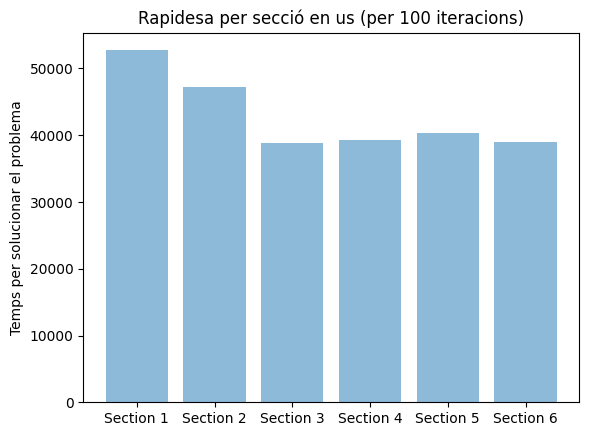

In [0]:
"""
Script en python per a visualitzar una comparativa entre els resultats.
"""

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def get_array_from_file(filename: str) -> list:
  with open(filename, "r") as f:
    arr = [int(line.split(".")[0]) for line in f]
  return arr


objects = ('Section 1', 'Section 2', 'Section 3', 'Section 4', 'Section 5', 'Section 6')
y_pos = np.arange(len(objects))
performance = get_array_from_file("dades.txt")

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Temps per solucionar el problema')
plt.title('Rapidesa per secció en us (per 100 iteracions)')

plt.show()